In [1]:
import torch 
import torch.nn as nn
import transformers
from dataset import ContrailsDataset
%load_ext autoreload
%autoreload 2

In [17]:
IMAGE_SIZE=256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = transformers.SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3", num_labels=2, image_size=IMAGE_SIZE).to(device) #<- head not pretrtained, we finetune head
# overwrite segformer head with our own modifications to use some new tricks
from models import SegformerDecodeHeadModified
model.decode_head = SegformerDecodeHeadModified(model.config).to(device)
model.eval()
# ignore the train warning, we load in our own weights later

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import evaluate

metric = evaluate.load("mean_iou")

In [4]:
import lightning as L
import torch.optim as optim
torch.set_float32_matmul_precision('medium')
train_dataset = ContrailsDataset("/data/contrails/train")
val_dataset =  ContrailsDataset("/data/contrails/validation")
class LitSegDeg(L.LightningModule):
    def __init__(self, model, lr=1e-4, batch_size=32):
        super().__init__()
        self.model = model
        self.lr = lr
        self.batch_size = batch_size
    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_dataset, num_workers=4, persistent_workers=True, batch_size=self.batch_size, prefetch_factor=8)
    def val_dataloader(self):
        return torch.utils.data.DataLoader(val_dataset, num_workers=4, persistent_workers=True, batch_size=self.batch_size, prefetch_factor=8)
    def validation_step(self, batch, batch_idx):
        x, y = batch
        z = self.model(pixel_values=x, labels=y)
        loss, logits = z.loss, z.logits
        labels = y
        self.log("val_loss", z.loss)
        if batch_idx % 50 == 0:
            with torch.no_grad():
                upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                # note that the metric expects predictions + labels as numpy arrays
                metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
            metrics = metric._compute(
                    predictions=predicted.cpu(),
                    references=labels.cpu(),
                    num_labels=2,
                    ignore_index=255,
                    reduce_labels=False, # we've already reduced the labels ourselves
            )
            self.log("val_mean_iou", metrics["mean_iou"])
        return z.loss
    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.model(pixel_values=x, labels=y)
        loss, logits = z.loss, z.logits
        labels = y
        self.log("train_loss", z.loss)
        if batch_idx % 50 == 0:
            with torch.no_grad():
                upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                # note that the metric expects predictions + labels as numpy arrays
                metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
            metrics = metric._compute(
                    predictions=predicted.cpu(),
                    references=labels.cpu(),
                    num_labels=2,
                    ignore_index=255,
                    reduce_labels=False, # we've already reduced the labels ourselves
            )
            self.log("train_mean_iou", metrics["mean_iou"])
        return z.loss
    def predict_step(self, batch, batch_idx):
        x, y = batch
        z = self.model(pixel_values=x, labels=y)
        loss, logits = z.loss, z.logits
        labels = y
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        return x, y, predicted

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [5]:
l_model = LitSegDeg.load_from_checkpoint("lightning_logs/version_0/checkpoints/epoch=7-step=9388.ckpt", model=model, batch_size=1)
l_model.eval()
test_dl = torch.utils.data.DataLoader(val_dataset, num_workers=4, persistent_workers=True, batch_size=1, prefetch_factor=8)
trainer = L.Trainer()
predictions = trainer.predict(l_model, test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [6]:
import numpy as np
import matplotlib.pyplot as plt
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def visualize(x, y, pred, save=""):
    band11, band14, band15 = x
    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(false_color)
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(false_color)
    ax.imshow(y, cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Ground truth contrail mask on false color image')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(false_color)
    ax.imshow(pred, cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Predicted contrail mask on false color image')
    if save != "":
        plt.savefig(save)
        plt.close()


In [7]:
actual_preds = []
for i in range(len(predictions)):
    if len(torch.unique(predictions[i][1])) > 1:
        actual_preds.append(i)

  0%|          | 0/552 [00:00<?, ?it/s]

 38%|███▊      | 207/552 [03:02<05:04,  1.13it/s]


KeyboardInterrupt: 

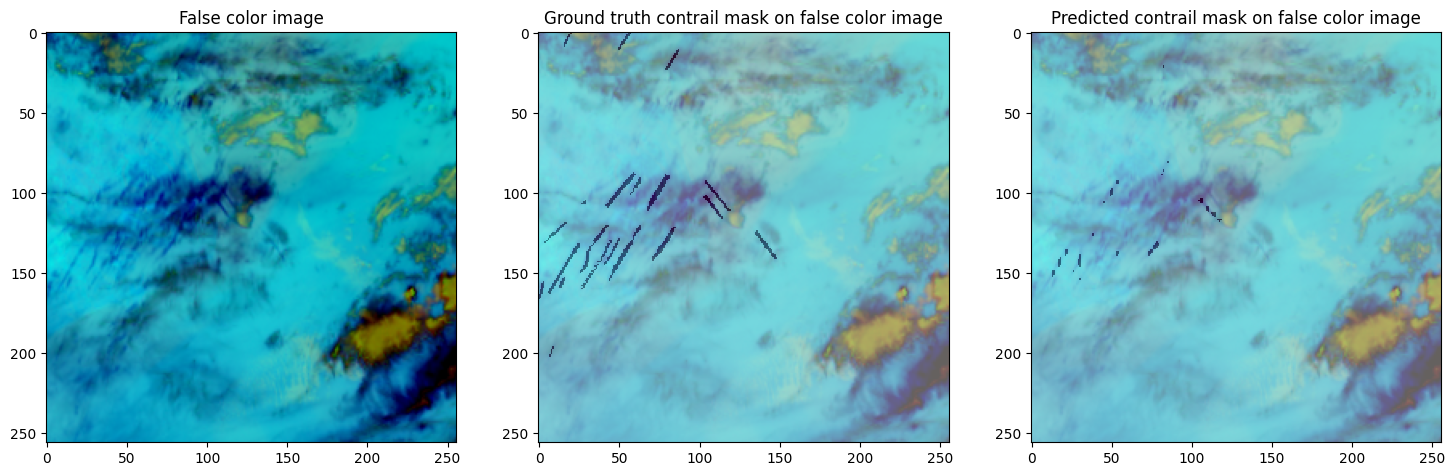

In [11]:
from tqdm import tqdm
for i in tqdm(range(len(actual_preds))):
    x, y, pred = predictions[actual_preds[i]]
    x = x[0]
    y = y[0]
    pred = pred[0]
    visualize(x, y, pred, save=f"inference/{i}.png")